In [3]:
%load_ext autoreload
%autoreload 2

import sys
if sys.path[-1] != "..": sys.path.append("../")

from qBN.qBNMC import qBNMC
from qBN.qBNRejection import qBNRejection
from XPs.qBNRT import qRuntime

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

import random
import numpy as np

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='1b6910ff55c1d3853e5c8e2ca2b0dbbc3b415fb897d26a6c272c63254527581c824aea1180585f706ab8263318f3c553549d136ca32952ef401abb54011eee33'
)

backend = service.get_backend("ibm_brisbane")

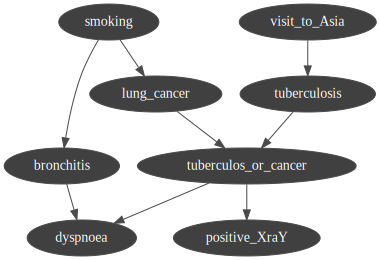

visit_to_Asia:Labelized({0|1}) 0
tuberculosis:Labelized({0|1}) 1
tuberculos_or_cancer:Labelized({0|1}) 2
positive_XraY:Labelized({0|1}) 3
lung_cancer:Labelized({0|1}) 4
smoking:Labelized({0|1}) 5
bronchitis:Labelized({0|1}) 6
dyspnoea:Labelized({0|1}) 7


In [3]:
asia_bn = gum.loadBN("../tutorials/bayes_nets/asia.bif")
gnb.showBN(asia_bn, size=20)
for n_id in asia_bn.nodes():
    print(asia_bn.variable(n_id), n_id)

In [4]:
def getRandomBinaryCPT(num_parents):
    if num_parents <= 0:
        r = random.random()
        return [r, 1-r]
    else:
        return [getRandomBinaryCPT(num_parents-1), getRandomBinaryCPT(num_parents-1)]

def randomChoice(elements, num_choice):
    res = set()
    for i in range(num_choice):
        chosen = random.choice(list(elements))
        elements.discard(chosen)
        res.add(chosen)
    return res

def modifyBinaryCPT(cpt, state, scaling):
    if len(cpt.shape) == 1:
        if state == 0:
            return [cpt[0]/scaling, 1-cpt[0]/scaling]
        else:
            return [1-cpt[1]/scaling, cpt[1]/scaling]
    else:
        return [modifyBinaryCPT(cpt[0], state, scaling), modifyBinaryCPT(cpt[1], state, scaling)]

In [5]:
binary_bn = gum.BayesNet('Binary BN')

for n_id in asia_bn.nodes():
    asia_bn.add(gum.LabelizedVariable(asia_bn.variable(n_id).name(), asia_bn.variable(n_id).description(), 2))

for tail, head in asia_bn.arcs():
    binary_bn.addArc(tail, head)

for n_id in asia_bn.nodes():
    binary_bn.cpt(n_id)[:] = getRandomBinaryCPT(len(binary_bn.parents(n_id)))

DuplicateLabel: [pyAgrum] Duplicate label: Unable to insert var with the name 'visit_to_Asia'.

In [ ]:
qbn = qBNMC(asia_bn)
qc = qbn.buildCircuit(add_measure=True)

In [ ]:
tbn = gum.fastBN("A->B<-C")

In [ ]:
tbn.cpt(1)[:] = old
tbn.cpt(1)

(pyAgrum.Potential<double>@0x5cd06b2342f0) 
             ||  B                |
A     |C     ||0        |1        |
------|------||---------|---------|
0     |0     || 0.3717  | 0.6283  |
1     |0     || 0.2127  | 0.7873  |
0     |1     || 0.8790  | 0.1210  |
1     |1     || 0.2791  | 0.7209  |

In [ ]:
tbn.cpt(1)[:] = modifyBinaryCPT(tbn.cpt(1), 0, 5)
tbn.cpt(1)

(pyAgrum.Potential<double>@0x6256126553d0) 
             ||  B                |
A     |C     ||0        |1        |
------|------||---------|---------|
0     |0     || 0.1461  | 0.8539  |
1     |0     || 0.0915  | 0.9085  |
0     |1     || 0.1280  | 0.8720  |
1     |1     || 0.0514  | 0.9486  |

In [ ]:
tbn.cpt(1)[:] = modifyBinaryCPT(tbn.cpt(1), 0, 1/5)
tbn.cpt(1)

(pyAgrum.Potential<double>@0x6256126553d0) 
             ||  B                |
A     |C     ||0        |1        |
------|------||---------|---------|
0     |0     || 0.7303  | 0.2697  |
1     |0     || 0.4573  | 0.5427  |
0     |1     || 0.6402  | 0.3598  |
1     |1     || 0.2569  | 0.7431  |

In [ ]:
scaling_min = 4
scaling_max = 6
num_runs = 10
num_evidence_var = 3
max_iter = 1

qinf_rt_list = list()
qinf_me_list = list()

mc_rt_list = list()
mc_me_list = list()

ev_prob_list = list()

for i in range(num_runs):

    #Randomly Chosen Evidence and Target
    n_ids = asia_bn.nodes()
    evidence = {ev_id: random.randint(0, 1) for ev_id in randomChoice(n_ids, num_evidence_var)}
    target = list(randomChoice(n_ids, 1))[0]

    scaling = random.randint(scaling_min, scaling_max)

    for n_id, n_state in evidence.items():
        print(asia_bn.cpt(n_id))
        asia_bn.cpt(n_id)[:] = modifyBinaryCPT(asia_bn.cpt(n_id), n_state, scaling)
        print(asia_bn.cpt(n_id))

    #Lazy Propagation Benchmark
    ie = gum.LazyPropagation(asia_bn)
    ie.setEvidence(evidence)
    ie.makeInference()
    print(f"Evidence: {evidence}, Target Node: {target}")
    print(f"Evidence probability ({num_evidence_var} values): {ie.evidenceProbability()}")
    ev_prob_list.append(ie.evidenceProbability())

    #Quantum Rejection Sampling
    qinf = qBNRejection(qbn)
    qrt = qRuntime(qinf, backend)
    qinf.setEvidence(evidence)
    qinf.setMaxIter(max_iter)
    qinf.makeInference(verbose=1)
    qinf_run_time = qrt.rejectionSamplingRuntime()
    qinf_max_error = (qinf.posterior(target).toarray() - ie.posterior(target).toarray()).max()
    print(f"QS - Run time: {qinf_run_time}, Max Error: {qinf_max_error}")
    qinf_rt_list.append(qinf_run_time)
    qinf_me_list.append(qinf_max_error)

    #Monte Carlo Classical Rejection Sampling
    mc = gum.MonteCarloSampling(asia_bn)
    mc.setEpsilon(1e-20)
    mc.setMaxTime(1e20)
    mc.setEvidence(evidence)
    mc.setMaxIter(max_iter)
    mc.makeInference()
    mc_run_time = mc.currentTime()
    mc_max_error = (mc.posterior(target).toarray() - ie.posterior(target).toarray()).max()
    print(f"MC - Run time: {mc_run_time}, Max Error: {mc_max_error}")
    mc_rt_list.append(mc_run_time)
    mc_me_list.append(mc_max_error)

    for n_id, n_state in evidence.items():
        asia_bn.cpt(n_id)[:] = modifyBinaryCPT(asia_bn.cpt(n_id), n_state, 1/scaling)



  visit_to_Asia    |
0        |1        |
---------|---------|
 0.0100  | 0.9900  |


  visit_to_Asia    |
0        |1        |
---------|---------|
 0.0017  | 0.9983  |


             ||  tuberculos_or_can|
tuberc|lung_c||0        |1        |
------|------||---------|---------|
0     |0     || 1.0000  | 0.0000  |
1     |0     || 1.0000  | 0.0000  |
0     |1     || 1.0000  | 0.0000  |
1     |1     || 0.0000  | 1.0000  |


             ||  tuberculos_or_can|
tuberc|lung_c||0        |1        |
------|------||---------|---------|
0     |0     || 0.1667  | 0.8333  |
1     |0     || 0.1667  | 0.8333  |
0     |1     || 0.1667  | 0.8333  |
1     |1     || 0.0000  | 1.0000  |


      ||  lung_cancer      |
smokin||0        |1        |
------||---------|---------|
0     || 0.1000  | 0.9000  |
1     || 0.0100  | 0.9900  |


      ||  lung_cancer      |
smokin||0        |1        |
------||---------|---------|
0     || 0.8500  | 0.1500  |
1     || 0.8350  | 0.1650  |

Evidence: {0: 0, 2: 0, 4: 

In [28]:
with open("asia_s5_nr100_nev3_mit10.txt", "w") as output:
    output.write(str(ev_prob_list)+"\n")
    output.write(str(qinf_rt_list)+"\n")
    output.write(str(mc_rt_list)+"\n")
    output.write(str(qinf_me_list)+"\n")
    output.write(str(mc_me_list))

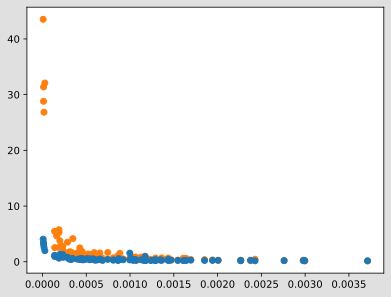

In [25]:
plt.scatter(ev_prob_list, mc_rt_list, color="tab:orange")
plt.scatter(ev_prob_list, qinf_rt_list, color="tab:blue")

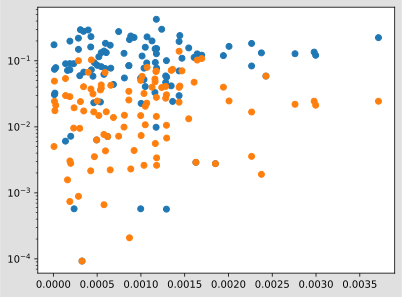

In [133]:
plt.scatter(ev_prob_list, qinf_me_list, color="tab:blue")
plt.scatter(ev_prob_list, mc_me_list, color="tab:orange")
plt.yscale('log')

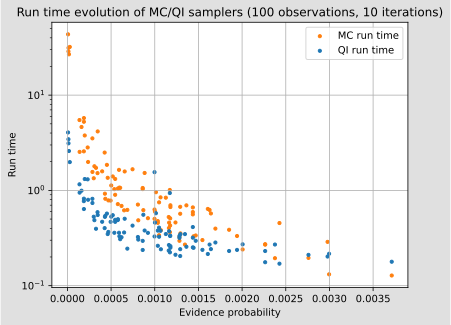

In [59]:
plt.scatter(ev_prob_list, mc_rt_list, color="tab:orange", s=10, label="MC run time")
plt.scatter(ev_prob_list, qinf_rt_list, color="tab:blue", s=10, label="QI run time")
plt.yscale('log')
plt.grid(True)
plt.xlabel('Evidence probability')
plt.ylabel('Run time')
plt.title(f'Run time evolution of MC/QI samplers ({num_runs} observations, {max_iter} iterations)')
plt.legend()

plt.savefig('../XPs/plots/RTProbScatter.png')
plt.show()

In [120]:
from sklearn.linear_model import LinearRegression 

inv_mc_rt_list = [1/rt for rt in mc_rt_list]
inv2_qinf_rt_list = [1/rt**2 for rt in qinf_rt_list]

prediction_range = np.array(range(1,101)).reshape(-1, 1)/2.5e4

reg_mc = LinearRegression().fit(np.array(ev_prob_list).reshape(-1, 1), np.array(inv_mc_rt_list))
inv_prediction_mc = reg_mc.predict(prediction_range)

reg_qinf = LinearRegression().fit(np.array(ev_prob_list).reshape(-1, 1), np.array(inv2_qinf_rt_list))
inv2_prediction_qinf = reg_qinf.predict(prediction_range)

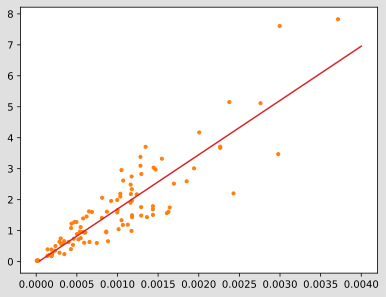

In [121]:
plt.scatter(ev_prob_list, inv_mc_rt_list, color="tab:orange", s=10, label="MC run time")
plt.plot(prediction_range, inv_prediction_mc, color="tab:red")

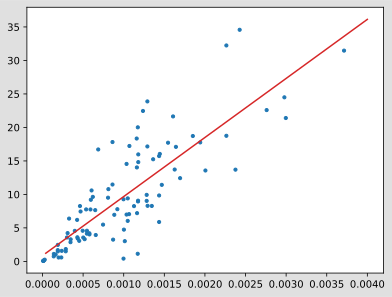

In [122]:
plt.scatter(ev_prob_list, inv2_qinf_rt_list, color="tab:blue", s=10, label="MC run time")
plt.plot(prediction_range, inv2_prediction_qinf, color="tab:red")

In [123]:
v_mc_func = np.vectorize(lambda x: 1/x)
prediction_mc = v_mc_func(inv_prediction_mc)

v_inf_func = np.vectorize(lambda x: 1/np.sqrt(x))
prediction_inf = v_inf_func(inv2_prediction_qinf)

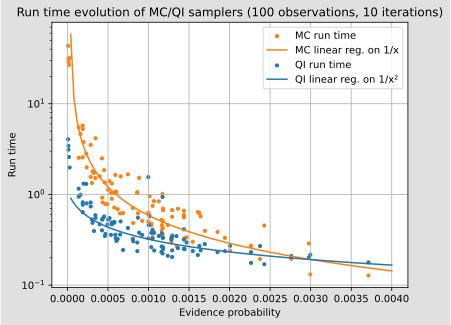

In [131]:
plt.scatter(ev_prob_list, mc_rt_list, color="tab:orange", s=10, label="MC run time")
plt.plot(prediction_range, prediction_mc, color="tab:orange", label="MC linear reg. on 1/x")
plt.scatter(ev_prob_list, qinf_rt_list, color="tab:blue", s=10, label="QI run time")
plt.plot(prediction_range, prediction_inf, color="tab:blue", label="QI linear reg. on 1/x\u00B2")

plt.yscale('log')
plt.grid(True)
plt.xlabel('Evidence probability')
plt.ylabel('Run time')
plt.title(f'Run time evolution of MC/QI samplers ({num_runs} observations, {max_iter} iterations)')
plt.legend()

plt.savefig('../XPs/plots/RTProbScatter.png')
plt.show()

In [19]:
s = 0
for i in range(10):
    mc = gum.MonteCarloSampling(asia_bn)
    mc.setEpsilon(1e-20)
    mc.setMaxTime(1e20)
    mc.setEvidence({0:0})
    mc.setMaxIter(1000)
    mc.makeInference()
    mc_run_time = mc.currentTime()
    s+= mc_run_time
    print(mc_run_time)

0.914621207
0.9546134070000001
0.956468156
0.9935231720000001
1.1669589249999999
1.115108625
1.116837988
0.969898427
0.9159305839999999
1.101532682


In [21]:
s/10

1.0205493173